In [1]:
## 設定
verbose = False

### 言語の割合の均等化
balanced = True

### LDA 用

## トピック数
n_topics = 15 # 30は多過ぎる？

## doc, term の設定
doc_type      = 'form'
doc_attr      = 'spell'
max_doc_size  = 12
##
term_size = 'character'
term_type = 'skippy3gram'
## skippy n-gram の結合範囲
max_distance_val = round(max_doc_size * 0.8)
print(f"max_distance_val: {max_distance_val}")

## ngram を包括的にするかどうか
ngram_is_inclusive = True

### DTM 構築

## term の最低頻度
term_min_freq = 2

## 高頻度 term の濫用指標: 大きくし過ぎないように．0.05 は十分に大きい
term_abuse_threshold = 0.05

max_distance_val: 10


In [2]:
import sys, os, random, re, glob
import pandas as pd
import pprint as pp
from functools import reduce

In [3]:
## load data to process
from pathlib import Path
import pprint as pp

wd = Path(".")
##
dirs = [ x for x in wd.iterdir() if x.is_dir() and not x.match(r"plot*") ]
if verbose:
    print(f"The following {len(dirs)} directories are potential targets:")
    pp.pprint(dirs)

## list up files in target directory 
wd = Path(".")
target_dir = "data-words" # can be changed
target_files = sorted(list(wd.glob(f"{target_dir}/*.csv")))
#
print(f"\n{target_dir} contains {len(target_files)} files to process")
pp.pprint(target_files)


data-words contains 9 files to process
[PosixPath('data-words/base-sound-English-r6e-originals.csv'),
 PosixPath('data-words/base-sound-German-r1a-original.csv'),
 PosixPath('data-words/base-spell-English-r6e-originals.csv'),
 PosixPath('data-words/base-spell-Esperanto-r0-orginal.csv'),
 PosixPath('data-words/base-spell-French-r0-originals.csv'),
 PosixPath('data-words/base-spell-German-r1a-originals.csv'),
 PosixPath('data-words/base-spell-Icelandic-r0-original.csv'),
 PosixPath('data-words/base-spell-Russian-r0-originals.csv'),
 PosixPath('data-words/base-spell-Swahili-r0-orginal.csv')]


In [4]:
import pandas as pd

## データ型の辞書
types = "spell sound freq".split(" ")
type_setting = { t : 0 for t in types }
print(type_setting)

## 言語名の辞書
langs = "english esperanto french german icelandic russian swahili".split(" ")
#langs = "english esperanto french german russian swahili".split(" ")
#langs = "english esperanto french german icelandic swahili".split(" ")
lang_setting = { lang : 0 for lang in langs }
print(lang_setting)

## 辞書と統合
settings = { 'form': None, **type_setting, **lang_setting }
print(settings)

{'spell': 0, 'sound': 0, 'freq': 0}
{'english': 0, 'esperanto': 0, 'french': 0, 'german': 0, 'icelandic': 0, 'russian': 0, 'swahili': 0}
{'form': None, 'spell': 0, 'sound': 0, 'freq': 0, 'english': 0, 'esperanto': 0, 'french': 0, 'german': 0, 'icelandic': 0, 'russian': 0, 'swahili': 0}


In [5]:
vars = list(settings.keys())
print(f"targe var names: {vars}")

d_parts = [ ]
for lang in langs:
    local_settings = settings.copy()
    print(f"processing: {lang}")
    try:
        for f in [ f for f in target_files if lang.capitalize() in str(f) ]:
            print(f"reading: {f}")
            # 言語名の指定
            local_settings[lang] = 1
            # 型名の指定
            for type in vars:
                if type in str(f):
                    local_settings[type] = 1
            #
            d = pd.read_csv(f, encoding='utf-8', sep = ",", on_bad_lines = 'skip') # Crucially, ...= skip
            df = pd.DataFrame(d, columns = vars)
            for var in [ var for var in (types + langs) if var != 'freq' ]:
                df[var] = local_settings[var]
            d_parts.append(df)
    except IndexError:
        pass
#
if verbose:
    d_parts

targe var names: ['form', 'spell', 'sound', 'freq', 'english', 'esperanto', 'french', 'german', 'icelandic', 'russian', 'swahili']
processing: english
reading: data-words/base-sound-English-r6e-originals.csv
reading: data-words/base-spell-English-r6e-originals.csv
processing: esperanto
reading: data-words/base-spell-Esperanto-r0-orginal.csv
processing: french
reading: data-words/base-spell-French-r0-originals.csv
processing: german
reading: data-words/base-sound-German-r1a-original.csv
reading: data-words/base-spell-German-r1a-originals.csv
processing: icelandic
reading: data-words/base-spell-Icelandic-r0-original.csv
processing: russian
reading: data-words/base-spell-Russian-r0-originals.csv
processing: swahili
reading: data-words/base-spell-Swahili-r0-orginal.csv


In [6]:
## データ統合

raw_df = pd.concat(d_parts)
raw_df

form  spell  sound freq  english  esperanto  french  german  \
0    æbəhəlimə      0      1    1        1          0       0       0   
1       ædmaɪə      0      1    1        1          0       0       0   
2      ædmɪʃən      0      1    1        1          0       0       0   
3    ædvæntɪdʒ      0      1    1        1          0       0       0   
4       ædvaɪs      0      1    1        1          0       0       0   
..         ...    ...    ...  ...      ...        ...     ...     ...   
703      zaidi      1      0    1        0          0       0       0   
704      ziara      1      0    1        0          0       0       0   
705       zima      1      0    1        0          0       0       0   
706       ziwa      1      0    1        0          0       0       0   
707      zoezi      1      0    1        0          0       0       0   

     icelandic  russian  swahili  
0            0        0        0  
1            0        0        0  
2            0        0        0  
3            0        0        0  
4            0        0        0  
..         ...      ...      ...  
703          0        0        1  
704          0        0        1  
705          0        0        1  
706          0        0        1  
707          0        0        1  

[14323 rows x 11 columns]

In [7]:
## 文字数の列を追加

raw_df['size'] = [ len(x) for x in raw_df[doc_type] ]
raw_df

form  spell  sound freq  english  esperanto  french  german  \
0    æbəhəlimə      0      1    1        1          0       0       0   
1       ædmaɪə      0      1    1        1          0       0       0   
2      ædmɪʃən      0      1    1        1          0       0       0   
3    ædvæntɪdʒ      0      1    1        1          0       0       0   
4       ædvaɪs      0      1    1        1          0       0       0   
..         ...    ...    ...  ...      ...        ...     ...     ...   
703      zaidi      1      0    1        0          0       0       0   
704      ziara      1      0    1        0          0       0       0   
705       zima      1      0    1        0          0       0       0   
706       ziwa      1      0    1        0          0       0       0   
707      zoezi      1      0    1        0          0       0       0   

     icelandic  russian  swahili  size  
0            0        0        0     9  
1            0        0        0     6  
2            0        0        0     7  
3            0        0        0     9  
4            0        0        0     6  
..         ...      ...      ...   ...  
703          0        0        1     5  
704          0        0        1     5  
705          0        0        1     4  
706          0        0        1     4  
707          0        0        1     5  

[14323 rows x 12 columns]

In [8]:
## 言語名= language の列を追加

check = False
language_vals = [ ]
for i, row in raw_df.iterrows():
    if check:
        print(row)
    for j, lang in enumerate(langs):
        if check:
            print(f"{i}: {lang}")
        if row[lang] == 1:
            language_vals.append(lang)
if verbose:
    print(language_vals)
    len(language_vals)
#
raw_df['language'] = language_vals
raw_df

form  spell  sound freq  english  esperanto  french  german  \
0    æbəhəlimə      0      1    1        1          0       0       0   
1       ædmaɪə      0      1    1        1          0       0       0   
2      ædmɪʃən      0      1    1        1          0       0       0   
3    ædvæntɪdʒ      0      1    1        1          0       0       0   
4       ædvaɪs      0      1    1        1          0       0       0   
..         ...    ...    ...  ...      ...        ...     ...     ...   
703      zaidi      1      0    1        0          0       0       0   
704      ziara      1      0    1        0          0       0       0   
705       zima      1      0    1        0          0       0       0   
706       ziwa      1      0    1        0          0       0       0   
707      zoezi      1      0    1        0          0       0       0   

     icelandic  russian  swahili  size language  
0            0        0        0     9  english  
1            0        0        0     6  english  
2            0        0        0     7  english  
3            0        0        0     9  english  
4            0        0        0     6  english  
..         ...      ...      ...   ...      ...  
703          0        0        1     5  swahili  
704          0        0        1     5  swahili  
705          0        0        1     4  swahili  
706          0        0        1     4  swahili  
707          0        0        1     5  swahili  

[14323 rows x 13 columns]

In [9]:
## 言語の選別

select_languages = True

selected_langs = re.split(r",\s*", "english, french, german, russian, swahili")
print(f"selected languages: {selected_langs}")

if select_languages:
    df_new = [ ]
    for lang in selected_langs:
        df_new.append(raw_df[raw_df[lang] == 1])
    raw_df = pd.concat(df_new)
#
raw_df

selected languages: ['english', 'french', 'german', 'russian', 'swahili']


form  spell  sound freq  english  esperanto  french  german  \
0    æbəhəlimə      0      1    1        1          0       0       0   
1       ædmaɪə      0      1    1        1          0       0       0   
2      ædmɪʃən      0      1    1        1          0       0       0   
3    ædvæntɪdʒ      0      1    1        1          0       0       0   
4       ædvaɪs      0      1    1        1          0       0       0   
..         ...    ...    ...  ...      ...        ...     ...     ...   
703      zaidi      1      0    1        0          0       0       0   
704      ziara      1      0    1        0          0       0       0   
705       zima      1      0    1        0          0       0       0   
706       ziwa      1      0    1        0          0       0       0   
707      zoezi      1      0    1        0          0       0       0   

     icelandic  russian  swahili  size language  
0            0        0        0     9  english  
1            0        0        0     6  english  
2            0        0        0     7  english  
3            0        0        0     9  english  
4            0        0        0     6  english  
..         ...      ...      ...   ...      ...  
703          0        0        1     5  swahili  
704          0        0        1     5  swahili  
705          0        0        1     4  swahili  
706          0        0        1     4  swahili  
707          0        0        1     5  swahili  

[12773 rows x 13 columns]

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_56499/1088473461.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


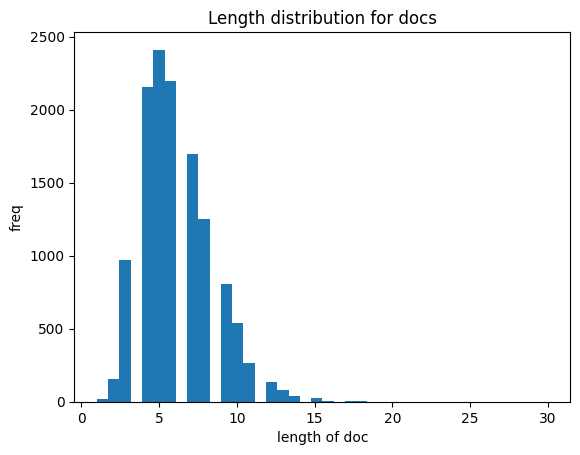

In [10]:
## 文字数の分布
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.hist(raw_df['size'], bins = 40)
ax.set_xlabel('length of doc')
ax.set_ylabel('freq')
plt.title(f"Length distribution for docs")
fig.show()

In [11]:
## 長さで濾過

print(f"max doc size: {max_doc_size}")
original_size = len(raw_df)
raw_df = raw_df[raw_df['size'] < max_doc_size]
filtered_size = len(raw_df)
print(f"{original_size - filtered_size} cases removed")

max doc size: 12
296 cases removed


In [12]:
## 結果の検査 1

for lang in langs:
    print(raw_df[lang].value_counts())

english
1    8249
0    4228
Name: count, dtype: int64
esperanto
0    12477
Name: count, dtype: int64
french
0    11492
1      985
Name: count, dtype: int64
german
0    10912
1     1565
Name: count, dtype: int64
icelandic
0    12477
Name: count, dtype: int64
russian
0    11504
1      973
Name: count, dtype: int64
swahili
0    11772
1      705
Name: count, dtype: int64


In [13]:
## 結果の検査 2

for type in types:
    print(raw_df[type].value_counts())

spell
1    7588
0    4889
Name: count, dtype: int64
sound
1    9814
0    2663
Name: count, dtype: int64
freq
1                  11495
1                    966
1 не                   1
1 то время как         1
1 северу               1
1 него                 1
1 будет                1
1 образом              1
1 мышь                 1
Name: count, dtype: int64


In [14]:
## 統合: 割合補正を適用

eng_reduct_factor = 0.2
if balanced:
    eng_df = raw_df[raw_df['english'] == 1]
    non_eng_df = raw_df[raw_df['english'] == 0]
    eng_reduced_df = eng_df.sample(round(len(eng_df) * eng_reduct_factor))
    raw_df = pd.concat([eng_reduced_df, non_eng_df])
raw_df

form  spell  sound freq  english  esperanto  french  german  \
3661     stuarts      1      1  1.0        1          0       0       0   
698        fæʃən      0      1    1        1          0       0       0   
1221    kəlɑmbʌs      0      1    1        1          0       0       0   
2450  mysterious      1      1  1.0        1          0       0       0   
3223     əfɛnsɪv      0      1    1        1          0       0       0   
...          ...    ...    ...  ...      ...        ...     ...     ...   
703        zaidi      1      0    1        0          0       0       0   
704        ziara      1      0    1        0          0       0       0   
705         zima      1      0    1        0          0       0       0   
706         ziwa      1      0    1        0          0       0       0   
707        zoezi      1      0    1        0          0       0       0   

      icelandic  russian  swahili  size language  
3661          0        0        0     7  english  
698           0        0        0     5  english  
1221          0        0        0     8  english  
2450          0        0        0    10  english  
3223          0        0        0     7  english  
...         ...      ...      ...   ...      ...  
703           0        0        1     5  swahili  
704           0        0        1     5  swahili  
705           0        0        1     4  swahili  
706           0        0        1     4  swahili  
707           0        0        1     5  swahili  

[5878 rows x 13 columns]

In [15]:
## 結果の検査 3

for lang in langs:
    print(raw_df[lang].value_counts())

english
0    4228
1    1650
Name: count, dtype: int64
esperanto
0    5878
Name: count, dtype: int64
french
0    4893
1     985
Name: count, dtype: int64
german
0    4313
1    1565
Name: count, dtype: int64
icelandic
0    5878
Name: count, dtype: int64
russian
0    4905
1     973
Name: count, dtype: int64
swahili
0    5173
1     705
Name: count, dtype: int64


In [16]:
## 順序のランダマイズ

import sklearn.utils
raw_df = sklearn.utils.shuffle(raw_df)

In [17]:
## データ名の指定
df = raw_df[raw_df[doc_attr] == 1]
print(f"doc_attr: {doc_attr}")
df

doc_attr: spell


form  spell  sound freq  english  esperanto  french  german  \
949   continuer      1      0  1.0        0          0       1       0   
2540   nowadays      1      1  1.0        1          0       0       0   
2370    minutes      1      1  1.0        1          0       0       0   
155         ваш      1      0   1         0          0       0       0   
95       bieten      1      1    1        0          0       0       1   
...         ...    ...    ...  ...      ...        ...     ...     ...   
668        wafu      1      0    1        0          0       0       0   
973       litre      1      0  1.0        0          0       1       0   
690      magnet      1      1    1        0          0       0       1   
777   localiser      1      0  1.0        0          0       1       0   
714      волосы      1      0   1         0          0       0       0   

      icelandic  russian  swahili  size language  
949           0        0        0     9   french  
2540          0        0        0     8  english  
2370          0        0        0     7  english  
155           0        1        0     3  russian  
95            0        0        0     6   german  
...         ...      ...      ...   ...      ...  
668           0        0        1     4  swahili  
973           0        0        0     5   french  
690           0        0        0     6   german  
777           0        0        0     9   french  
714           0        1        0     6  russian  

[4265 rows x 13 columns]

In [18]:
df[df['english'] == 1]

form  spell  sound freq  english  esperanto  french  german  \
2540    nowadays      1      1  1.0        1          0       0       0   
2370     minutes      1      1  1.0        1          0       0       0   
1391    february      1      1  1.0        1          0       0       0   
2147     leising      1      1  1.0        1          0       0       0   
974   depression      1      1  1.0        1          0       0       0   
...          ...    ...    ...  ...      ...        ...     ...     ...   
230   attendance      1      1  1.0        1          0       0       0   
1487     foreign      1      1  1.0        1          0       0       0   
2346      metric      1      1  1.0        1          0       0       0   
1264    european      1      1  1.0        1          0       0       0   
578        chalk      1      1  1.0        1          0       0       0   

      icelandic  russian  swahili  size language  
2540          0        0        0     8  english  
2370          0        0        0     7  english  
1391          0        0        0     8  english  
2147          0        0        0     7  english  
974           0        0        0    10  english  
...         ...      ...      ...   ...      ...  
230           0        0        0    10  english  
1487          0        0        0     7  english  
2346          0        0        0     6  english  
1264          0        0        0     8  english  
578           0        0        0     5  english  

[825 rows x 13 columns]

In [19]:
## ngram の追加

import sys
sys.path.append('..')

import re
import ngrams
import importlib
importlib.reload(ngrams)
import ngrams_skippy

bases = df[doc_type]

## 1gram 列の追加
#sep = r""
#unigrams = [ list(filter(lambda x: len(x) > 0, y)) for y in [ re.split(sep, z) for z in bases ] ]
unigrams = ngrams.gen_unigrams(bases, sep = r"", check = False)
if verbose:
    random.sample(unigrams, 5)
#
df['1gram'] = unigrams
#df.loc[:,'1gram'] = unigrams
df

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_56499/1248262955.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['1gram'] = unigrams


form  spell  sound freq  english  esperanto  french  german  \
949   continuer      1      0  1.0        0          0       1       0   
2540   nowadays      1      1  1.0        1          0       0       0   
2370    minutes      1      1  1.0        1          0       0       0   
155         ваш      1      0   1         0          0       0       0   
95       bieten      1      1    1        0          0       0       1   
...         ...    ...    ...  ...      ...        ...     ...     ...   
668        wafu      1      0    1        0          0       0       0   
973       litre      1      0  1.0        0          0       1       0   
690      magnet      1      1    1        0          0       0       1   
777   localiser      1      0  1.0        0          0       1       0   
714      волосы      1      0   1         0          0       0       0   

      icelandic  russian  swahili  size language                        1gram  
949           0        0        0     9   french  [c, o, n, t, i, n, u, e, r]  
2540          0        0        0     8  english     [n, o, w, a, d, a, y, s]  
2370          0        0        0     7  english        [m, i, n, u, t, e, s]  
155           0        1        0     3  russian                    [в, а, ш]  
95            0        0        0     6   german           [b, i, e, t, e, n]  
...         ...      ...      ...   ...      ...                          ...  
668           0        0        1     4  swahili                 [w, a, f, u]  
973           0        0        0     5   french              [l, i, t, r, e]  
690           0        0        0     6   german           [m, a, g, n, e, t]  
777           0        0        0     9   french  [l, o, c, a, l, i, s, e, r]  
714           0        1        0     6  russian           [в, о, л, о, с, ы]  

[4265 rows x 14 columns]

In [20]:
## 2gram列の追加

bigrams = ngrams.gen_bigrams(bases, sep = r"", check = False)

## 包括的 2gram の作成
if ngram_is_inclusive:
    bigrams = [ [*b, *u] for b, u in zip(bigrams, unigrams) ]

if verbose:
    print(random.sample(bigrams, 3))

In [21]:
df['2gram'] = bigrams
if verbose:
    df

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_56499/1480305306.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['2gram'] = bigrams


In [22]:
## 3gram列の追加

trigrams = ngrams.gen_trigrams(bases, sep = r"", check = False)

## 包括的 3gram の作成
if ngram_is_inclusive:
    trigrams = [ [ *t, *b ] for t, b in  zip(trigrams, bigrams) ]

if verbose:
    print(random.sample(trigrams, 3))

In [23]:
df['3gram'] = trigrams
if verbose:
    df

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_56499/3715201492.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['3gram'] = trigrams


In [24]:
## skippy 2grams の生成

import sys
sys.path.append("..") # library path に一つ上の階層を追加

import ngrams_skippy

skippy_2grams = [ ngrams_skippy.generate_skippy_bigrams(x,
                                                         missing_mark = '…',
                                                         max_distance = max_distance_val, check = False)
                  for x in df['1gram'] ]

## 包括的 skippy 2-grams の生成
if ngram_is_inclusive:
    for i, b2 in enumerate(skippy_2grams):
        b2.extend(unigrams[i])
#
if verbose:
    random.sample(skippy_2grams, 3)

In [25]:
## skippy 2gram 列の追加

df['skippy2gram'] = skippy_2grams
df

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_56499/3263801935.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['skippy2gram'] = skippy_2grams


form  spell  sound freq  english  esperanto  french  german  \
949   continuer      1      0  1.0        0          0       1       0   
2540   nowadays      1      1  1.0        1          0       0       0   
2370    minutes      1      1  1.0        1          0       0       0   
155         ваш      1      0   1         0          0       0       0   
95       bieten      1      1    1        0          0       0       1   
...         ...    ...    ...  ...      ...        ...     ...     ...   
668        wafu      1      0    1        0          0       0       0   
973       litre      1      0  1.0        0          0       1       0   
690      magnet      1      1    1        0          0       0       1   
777   localiser      1      0  1.0        0          0       1       0   
714      волосы      1      0   1         0          0       0       0   

      icelandic  russian  swahili  size language                        1gram  \
949           0        0        0     9   french  [c, o, n, t, i, n, u, e, r]   
2540          0        0        0     8  english     [n, o, w, a, d, a, y, s]   
2370          0        0        0     7  english        [m, i, n, u, t, e, s]   
155           0        1        0     3  russian                    [в, а, ш]   
95            0        0        0     6   german           [b, i, e, t, e, n]   
...         ...      ...      ...   ...      ...                          ...   
668           0        0        1     4  swahili                 [w, a, f, u]   
973           0        0        0     5   french              [l, i, t, r, e]   
690           0        0        0     6   german           [m, a, g, n, e, t]   
777           0        0        0     9   french  [l, o, c, a, l, i, s, e, r]   
714           0        1        0     6  russian           [в, о, л, о, с, ы]   

                                                  2gram  \
949   [co, on, nt, ti, in, nu, ue, er, c, o, n, t, i...   
2540  [no, ow, wa, ad, da, ay, ys, n, o, w, a, d, a,...   
2370      [mi, in, nu, ut, te, es, m, i, n, u, t, e, s]   
155                                   [ва, аш, в, а, ш]   
95               [bi, ie, et, te, en, b, i, e, t, e, n]   
...                                                 ...   
668                            [wa, af, fu, w, a, f, u]   
973                     [li, it, tr, re, l, i, t, r, e]   
690              [ma, ag, gn, ne, et, m, a, g, n, e, t]   
777   [lo, oc, ca, al, li, is, se, er, l, o, c, a, l...   
714              [во, ол, ло, ос, сы, в, о, л, о, с, ы]   

                                                  3gram  \
949   [con, ont, nti, tin, inu, nue, uer, co, on, nt...   
2540  [now, owa, wad, ada, day, ays, no, ow, wa, ad,...   
2370  [min, inu, nut, ute, tes, mi, in, nu, ut, te, ...   
155                              [ваш, ва, аш, в, а, ш]   
95    [bie, iet, ete, ten, bi, ie, et, te, en, b, i,...   
...                                                 ...   
668                  [waf, afu, wa, af, fu, w, a, f, u]   
973      [lit, itr, tre, li, it, tr, re, l, i, t, r, e]   
690   [mag, agn, gne, net, ma, ag, gn, ne, et, m, a,...   
777   [loc, oca, cal, ali, lis, ise, ser, lo, oc, ca...   
714   [вол, оло, лос, осы, во, ол, ло, ос, сы, в, о,...   

                                            skippy2gram  
949   [co, c…n, c…t, c…i, c…u, c…e, c…r, on, o…t, o…...  
2540  [no, n…w, n…a, n…d, n…y, n…s, ow, o…a, o…d, o…...  
2370  [mi, m…n, m…u, m…t, m…e, m…s, in, i…u, i…t, i…...  
155                              [ва, в…ш, аш, в, а, ш]  
95    [bi, b…e, b…t, b…n, ie, i…t, i…e, i…n, et, e…e...  
...                                                 ...  
668             [wa, w…f, w…u, af, a…u, fu, w, a, f, u]  
973   [li, l…t, l…r, l…e, it, i…r, i…e, tr, t…e, re,...  
690   [ma, m…g, m…n, m…e, m…t, ag, a…n, a…e, a…t, gn...  
777   [lo, l…c, l…a, l…l, l…i, l…s, l…e, l…r, oc, o…...  
714   [во, в…л, в…о, в…с, в…ы, ол, о…о, о…с, о…ы, ло...  

[4265 rows x 17 columns]

In [26]:
## skippy 3grams の生成

import sys
sys.path.append("..") # library path に一つ上の階層を追加

import ngrams_skippy

skippy_3grams = [ ngrams_skippy.generate_skippy_trigrams(x,
                                                         missing_mark = '…',
                                                         max_distance = max_distance_val, check = False)
                  for x in df['1gram'] ]

## 包括的 skippy 3-grams の生成
if ngram_is_inclusive:
    for i, t2 in enumerate(skippy_3grams):
        t2.extend(skippy_2grams[i])
#
if verbose:
    random.sample(skippy_3grams, 3)

In [27]:
## skippy 3gram 列の追加

df['skippy3gram'] = skippy_3grams
df

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_56499/1159231133.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['skippy3gram'] = skippy_3grams


form  spell  sound freq  english  esperanto  french  german  \
949   continuer      1      0  1.0        0          0       1       0   
2540   nowadays      1      1  1.0        1          0       0       0   
2370    minutes      1      1  1.0        1          0       0       0   
155         ваш      1      0   1         0          0       0       0   
95       bieten      1      1    1        0          0       0       1   
...         ...    ...    ...  ...      ...        ...     ...     ...   
668        wafu      1      0    1        0          0       0       0   
973       litre      1      0  1.0        0          0       1       0   
690      magnet      1      1    1        0          0       0       1   
777   localiser      1      0  1.0        0          0       1       0   
714      волосы      1      0   1         0          0       0       0   

      icelandic  russian  swahili  size language                        1gram  \
949           0        0        0     9   french  [c, o, n, t, i, n, u, e, r]   
2540          0        0        0     8  english     [n, o, w, a, d, a, y, s]   
2370          0        0        0     7  english        [m, i, n, u, t, e, s]   
155           0        1        0     3  russian                    [в, а, ш]   
95            0        0        0     6   german           [b, i, e, t, e, n]   
...         ...      ...      ...   ...      ...                          ...   
668           0        0        1     4  swahili                 [w, a, f, u]   
973           0        0        0     5   french              [l, i, t, r, e]   
690           0        0        0     6   german           [m, a, g, n, e, t]   
777           0        0        0     9   french  [l, o, c, a, l, i, s, e, r]   
714           0        1        0     6  russian           [в, о, л, о, с, ы]   

                                                  2gram  \
949   [co, on, nt, ti, in, nu, ue, er, c, o, n, t, i...   
2540  [no, ow, wa, ad, da, ay, ys, n, o, w, a, d, a,...   
2370      [mi, in, nu, ut, te, es, m, i, n, u, t, e, s]   
155                                   [ва, аш, в, а, ш]   
95               [bi, ie, et, te, en, b, i, e, t, e, n]   
...                                                 ...   
668                            [wa, af, fu, w, a, f, u]   
973                     [li, it, tr, re, l, i, t, r, e]   
690              [ma, ag, gn, ne, et, m, a, g, n, e, t]   
777   [lo, oc, ca, al, li, is, se, er, l, o, c, a, l...   
714              [во, ол, ло, ос, сы, в, о, л, о, с, ы]   

                                                  3gram  \
949   [con, ont, nti, tin, inu, nue, uer, co, on, nt...   
2540  [now, owa, wad, ada, day, ays, no, ow, wa, ad,...   
2370  [min, inu, nut, ute, tes, mi, in, nu, ut, te, ...   
155                              [ваш, ва, аш, в, а, ш]   
95    [bie, iet, ete, ten, bi, ie, et, te, en, b, i,...   
...                                                 ...   
668                  [waf, afu, wa, af, fu, w, a, f, u]   
973      [lit, itr, tre, li, it, tr, re, l, i, t, r, e]   
690   [mag, agn, gne, net, ma, ag, gn, ne, et, m, a,...   
777   [loc, oca, cal, ali, lis, ise, ser, lo, oc, ca...   
714   [вол, оло, лос, осы, во, ол, ло, ос, сы, в, о,...   

                                            skippy2gram  \
949   [co, c…n, c…t, c…i, c…u, c…e, c…r, on, o…t, o…...   
2540  [no, n…w, n…a, n…d, n…y, n…s, ow, o…a, o…d, o…...   
2370  [mi, m…n, m…u, m…t, m…e, m…s, in, i…u, i…t, i…...   
155                              [ва, в…ш, аш, в, а, ш]   
95    [bi, b…e, b…t, b…n, ie, i…t, i…e, i…n, et, e…e...   
...                                                 ...   
668             [wa, w…f, w…u, af, a…u, fu, w, a, f, u]   
973   [li, l…t, l…r, l…e, it, i…r, i…e, tr, t…e, re,...   
690   [ma, m…g, m…n, m…e, m…t, ag, a…n, a…e, a…t, gn...   
777   [lo, l…c, l…a, l…l, l…i, l…s, l…e, l…r, oc, o…...   
714   [во, в…л, в…о, в…с, в…ы, ол, о…о, о…с, о…ы, ло...   

                      

In [28]:
## LDA 構築の基になる document-term matrix (dtm) を構築

from gensim.corpora.dictionary import Dictionary

bots = df[term_type]
diction = Dictionary(bots)

## 結果の確認
print(diction)

Dictionary<37030 unique tokens: ['c', 'co', 'con', 'co…e', 'co…i']...>


In [29]:
## diction の濾過

import copy
diction_copy = copy.deepcopy(diction)

## filter適用: 実は諸刃の刃で，token数が少ない時には適用しない方が良い
print(f"min freq filter: {term_min_freq}")
print(f"abuse filter: {term_abuse_threshold}")

apply_filter = True
if apply_filter:
    diction_copy.filter_extremes(no_below = term_min_freq, no_above = term_abuse_threshold)

## check
print(diction_copy)

min freq filter: 2
abuse filter: 0.05
Dictionary<20876 unique tokens: ['co', 'con', 'co…e', 'co…i', 'co…n']...>


In [30]:
## Corpus (gensim の用語では corpus) の構築

corpus = [ diction.doc2bow(bot) for bot in bots ]

## check
check = True
if verbose:
    sample_n = 5
    print(random.sample(corpus, sample_n))
#
print(f"Number of documents: {len(corpus)}")

Number of documents: 4265


In [31]:
## LDA モデルの構築

from gensim.models import LdaModel
#from tqdm import tqdm

## LDAモデル
print(f"Building LDA model with n_topics: {n_topics}")
lda = LdaModel(corpus, id2word = diction, num_topics = n_topics, alpha = 0.01)
#
print(lda) # print(..)しないと中身が見れない

Building LDA model with n_topics: 15
LdaModel<num_terms=37030, num_topics=15, decay=0.5, chunksize=2000>


In [32]:
%%capture --no-display

## LDA のtopic ごとに，関連度の高い term を表示

import pandas as pd

n_terms = 20 # topic ごとに表示する term 数の指定
topic_dfs = [ ]
for topic in range(n_topics):
    terms = [ ]
    for i, prob in lda.get_topic_terms(topic, topn = n_terms):
        terms.append(diction.id2token[ int(i) ])
    #
    topic_dfs.append(pd.DataFrame([terms], index = [ f'topic {topic+1}' ]))
#
topic_term_df = pd.concat(topic_dfs)

## Table で表示
topic_term_df.T

topic 1 topic 2 topic 3 topic 4 topic 5 topic 6 topic 7 topic 8 topic 9  \
0        с       к       a       l       e       a       a       n       i   
1        а       о       d       a       r       m       p       a       u   
2        ь       а       n       i       n       l       u       я       a   
3        о       т       i      li       i       e       r       т       h   
4        т       и       e       e     e…e       i       l       а       e   
5        и       е      nd       u      en       n       e       н       s   
6        л       ь     a…i     l…a       c     a…a       c       с       l   
7      с…ь       с     a…d       k       d      al       o       i       c   
8      а…ь       д      an   a…i…a      er       w     a…u       и       r   
9        e       в     a…a      el      re      le       t      an       m   
10       п       у       m    li…a     r…n       o       m     з…л       f   
11      ть      ть       k       t     r…e       t       f   а…с…ь     i…i   
12       m     а…ь     a…e       w     i…e      wa     p…a      ся     u…i   
13     а…т      ка       l     a…l     n…e       k    о…да       g     a…i   
14     и…ь     о…а       t     ali     e…r      na       н     ч…ь     i…e   
15       n       з     n…e     u…l       g       u   л…н…й       u       k   
16    а…ть      ат     m…a     a…a       t     m…a     c…l    ч…ть     u…e   
17     с…т     у…ь     m…i    li…h     c…e       b       n     ч…т       t   
18    с…ть       н     and     i…a     n…r     a…l       k     i…a     i…h   
19     т…ь     к…а       r     a…e       l       z     a…a    s…na      ch   

   topic 10 topic 11 topic 12 topic 13 topic 14 topic 15  
0         o        e        a        е        o        e  
1         l        t        b        о        t        r  
2       é…o        s        h        т        u        o  
3         e        i       ba        с        n        и  
4     m…d…e        n        s        р        a      r…e  
5      vo…l        a      a…a        н        i        i  
6         y        r        l        а       to        p  
7        mé        o        e        д      o…o      o…e  
8       o…l        u        r        r       on      ord  
9      а…то      e…e        n        м        k      и…и  
10        а        g       ha        и       ou     с…ла  
11        a        m        d        e      u…n       ли  
12       vo      i…e        i        ж      u…a      v…r  
13       od      a…e      o…a      е…е      u…u       рм  
14    é…o…e      s…n        c      д…т      o…t      рма  
15      v…l      s…e      h…l      е…т      o…a       сд  
16     r…el      e…n        o        ь      u…i     сд…л  
17       oy        p      d…a        ы        h     сд…а  
18        t       te       ya        л        s     с…ел  
19      o…e      t…e        y        в      t…n      сде

In [33]:
%%capture --no-display

## pyLDAvis を使った結果 LDA の可視化: 階層クラスタリングより詳しい

import pyLDAvis

#installed_version = sys.version
installed_version = pyLDAvis.__version__

print(f"installed_version: {installed_version}")

if float(installed_version[:3]) > 3.1:
    import pyLDAvis.gensim_models as gensimvis
else:
    import pyLDAvis.gensim as gensimvis
#
pyLDAvis.enable_notebook()

#
lda_used     = lda
corpus_used  = corpus
diction_used = diction

## 実行パラメター
use_tSNE = False
if use_tSNE:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used, mds = 'tsne',
                            n_jobs = 1, sort_topics = False)
else:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used,
                            n_jobs = 1, sort_topics = False)
#
pyLDAvis.display(vis)

## 結果について
## topic を表わす円の重なりが多いならn_topics が多過ぎる可能性がある．
## ただし2Dで重なっていても，3Dなら重なっていない可能性もある

In [34]:
## LDA がD に対して生成した topics の弁別性を確認

## 得られたtopics を確認
topic_dist = lda.get_topics()
if verbose:
    topic_dist

In [35]:
## 検査 1: topic ごとに分布の和を取る

print(topic_dist.sum(axis = 1))

[0.99999994 0.9999999  1.         1.         1.         0.99999994
 0.99999994 1.         1.0000001  1.0000001  1.0000001  1.
 0.99999994 1.         0.99999994]


In [36]:
## 検査 2: 総和を求める: n_topics にほぼ等しいなら正常

print(topic_dist.sum())

14.999998


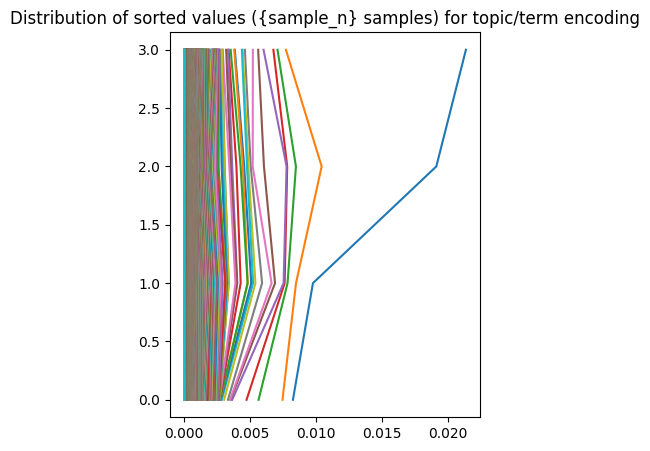

In [37]:
## term エンコード値の分布を確認

import matplotlib.pyplot as plt

plt.figure(figsize = (4,5))

sampling_rate = 0.3
df_size = len(topic_dist)
sample_n = round(df_size * sampling_rate)
topic_sampled = random.sample(list(topic_dist), sample_n)

T = sorted([ sorted(x, reverse = True) for x in topic_sampled ])

plt.plot(T, range(len(T)))
plt.title("Distribution of sorted values ({sample_n} samples) for topic/term encoding")
plt.show()

In [38]:
## tSNE を使った topics のグループ化 (3D)

from sklearn.manifold import TSNE
import numpy as np

## tSNE のパラメターを設定
## n_components は射影先の空間の次元: n_components = 3 なら3次元空間に射影
## perplexity は結合の強さを表わす指数で，値に拠って結果が代わるので，色々な値を試すと良い

#perplexity_val = 10 # 大き過ぎると良くない
top_perplexity_reduct_rate = 0.3
perplexity_val = round(len(topic_dist) * top_perplexity_reduct_rate)
topic_tSNE_3d = TSNE(n_components = 3, random_state = 0, perplexity = perplexity_val, n_iter = 1000)

## データに適用
top_tSNE_3d_fitted = topic_tSNE_3d.fit_transform(np.array(topic_dist))

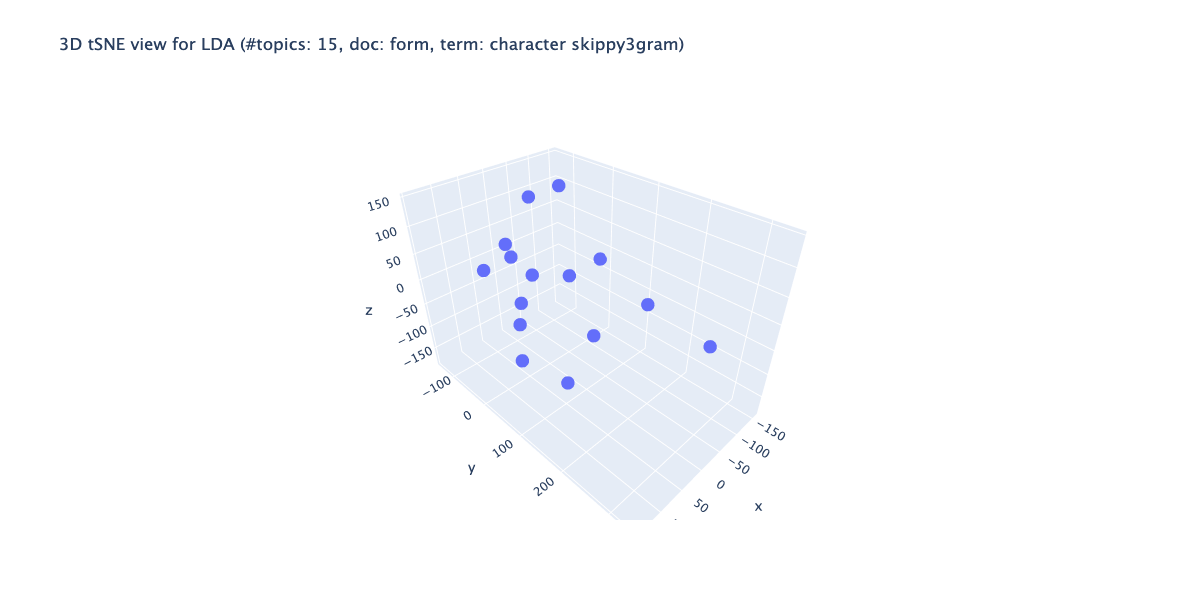

In [39]:
## Plotlyを使って tSNE の結果の可視化 (3D)

#import plotly.express as pex
import plotly.graph_objects as go
import numpy as np

top_tSNE = top_tSNE_3d_fitted
fig = go.Figure(data = [go.Scatter3d(x = top_tSNE[:,0], y = top_tSNE[:,1], z = top_tSNE[:,2],
                                     mode = 'markers')])

## 3D 散布図にラベルを追加する処理は未実装
title_val = f"3D tSNE view for LDA (#topics: {n_topics}, doc: {doc_type}, term: {term_size} {term_type})"
fig.update_layout(autosize = False,
                  width = 600, height = 600, title = title_val)
fig.show()

In [40]:
## 構築した LDA モデルを使って文(書)を分類する

## .get_document_topics(..) は　minimu_probability = 0としないと
## topic の値が小さい場合に値を返さないので，

## パラメター

ntopics = n_topics # LDA の構築の最に指定した値を使う

check      = False
encoding = [ ]
for i, row in df.iterrows():
    if check:
        print(f"row: {row}")
    doc = row[doc_type]
    bot = row[term_type]
    ## get_document_topics(..) では　minimu_probability = 0 としないと
    ## 値が十分に大きな topics に関してだけ値が取れる
    enc = lda.get_document_topics(diction.doc2bow(bot), minimum_probability = 0)
    if check:
        print(f"enc: {enc}")
    encoding.append(enc)
#
len(encoding)

4265

In [41]:
## enc 列の追加

#df['enc'] = np.array(encoding) # This flattens arrays
#df['enc'] = list(encoding) # ineffective
df['enc'] = [ list(map(lambda x: x[1], y)) for y in encoding ]
if verbose:
    df['enc']

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_56499/1047258704.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



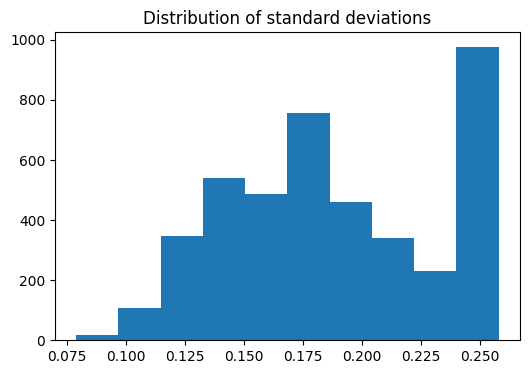

In [42]:
## エンコーディングのstd の分布を見る

from scipy.stats import tstd
from matplotlib import pyplot as plt

plt.figure(figsize = (6,4))

std_data = [ tstd(x) for x in df['enc'] ]
plt.hist(std_data)

plt.title("Distribution of standard deviations")
plt.show()

In [43]:
## doc のエンコーディング

## 一様分布の事例を除外

from scipy.stats import tstd # standard deviation の計算用

print(f"{len(df)} instances before filtering")

check = False

doc_enc = df['enc']
max_std = max([ tstd(x) for x in doc_enc])
if check: print(f"std max: {max_std}")

min_std = min([ tstd(x) for x in doc_enc])
if check: print(f"std min: {min_std}")

first_min_std = list(sorted(set([ tstd(x) for x in doc_enc])))[-0]
print(f"std 1st min: {first_min_std}")

second_min_std = list(sorted(set([ tstd(x) for x in doc_enc])))[-1]
print(f"std 2nd min: {second_min_std}")

4265 instances before filtering
std 1st min: 0.07870918921727707
std 2nd min: 0.25798070562892134


In [44]:
## df_filtered の定義

## 閾値は2番目に小さい値より小さく最小値よりは大きな値であるべき
std_threshold = second_min_std / 4 # 穏健な値を得るために4で割った
print(f"std_threshold: {std_threshold}")

## Rっぽい次のコードは通らない
#df_filtered = df[ df['encoding'] > std_threshold ]

## 通るのは次のコード: Creating a list of True/False and apply it to DataFrame 
std_tested = [ False if tstd(x) < std_threshold else True for x in df['enc'] ]
df_filtered = df[ std_tested ]
#
print(f"{len(df_filtered)} instances after filtering ({len(df) - len(df_filtered)} instances removed)")

std_threshold: 0.06449517640723033
4265 instances after filtering (0 instances removed)


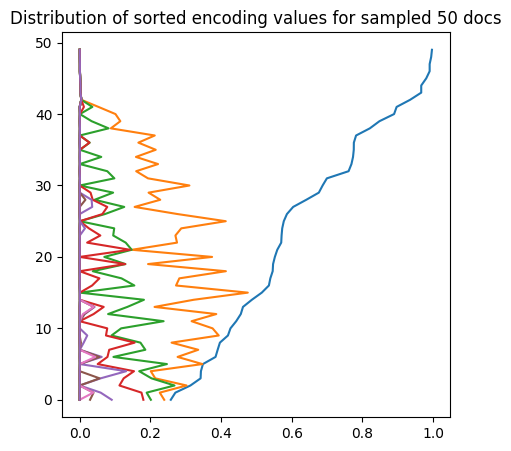

In [45]:
## doc エンコード値の分布を確認

sample_n = 50
E = sorted([ sorted(x, reverse = True) for x in df_filtered['enc'].sample(sample_n) ])

plt.figure(figsize = (5,5))
plt.plot(E, range(len(E)))
plt.title(f"Distribution of sorted encoding values for sampled {sample_n} docs")
plt.show()

In [46]:
len(df_filtered['language'])

4265

In [47]:
## tSNE 用の事例サンプリング = tSNE_df の定義

tSNE_sampling = True
tSNE_sampling_rate = 0.33
if tSNE_sampling:
    tSNE_df_original = df_filtered.copy()
    sample_n = round(len(tSNE_df_original) * tSNE_sampling_rate)
    tSNE_df = tSNE_df_original.sample(sample_n)
    print(f"tSNE_df has {len(tSNE_df)} rows after sampling")
else:
    tSNE_df = df_filtered

tSNE_df has 1407 rows after sampling


In [48]:
tSNE_df.columns

Index(['form', 'spell', 'sound', 'freq', 'english', 'esperanto', 'french',
       'german', 'icelandic', 'russian', 'swahili', 'size', 'language',
       '1gram', '2gram', '3gram', 'skippy2gram', 'skippy3gram', 'enc'],
      dtype='object')

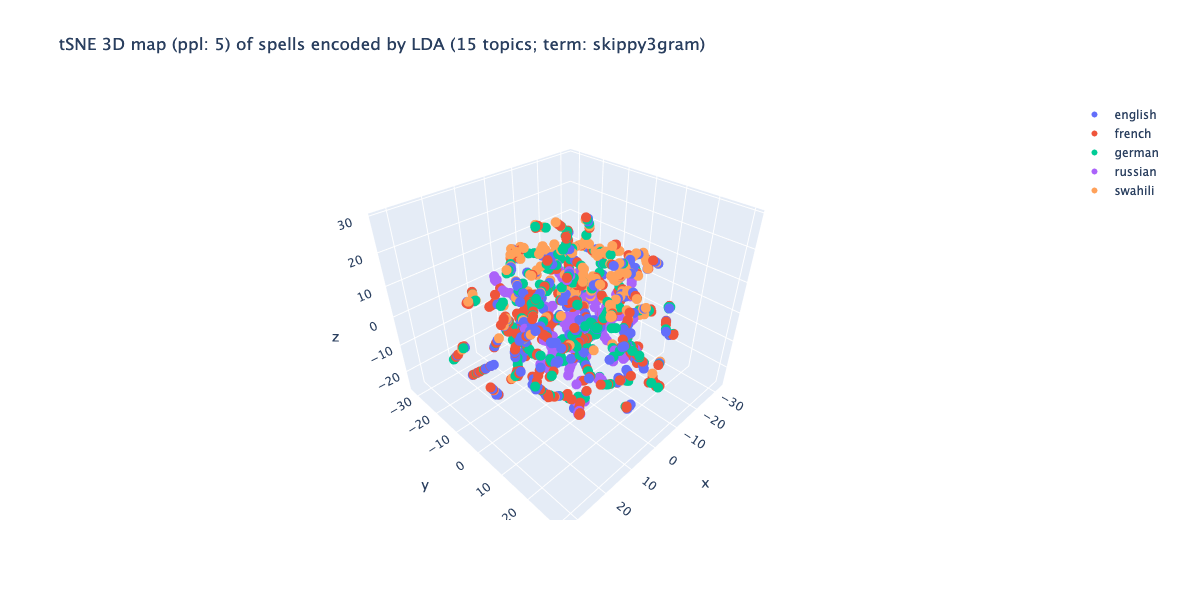

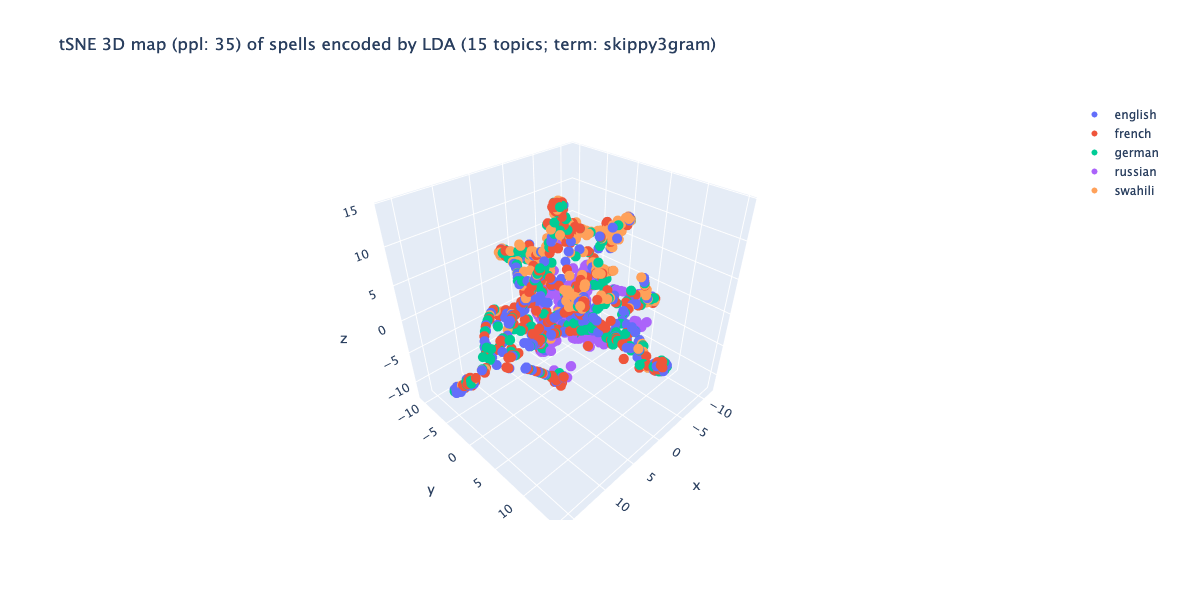

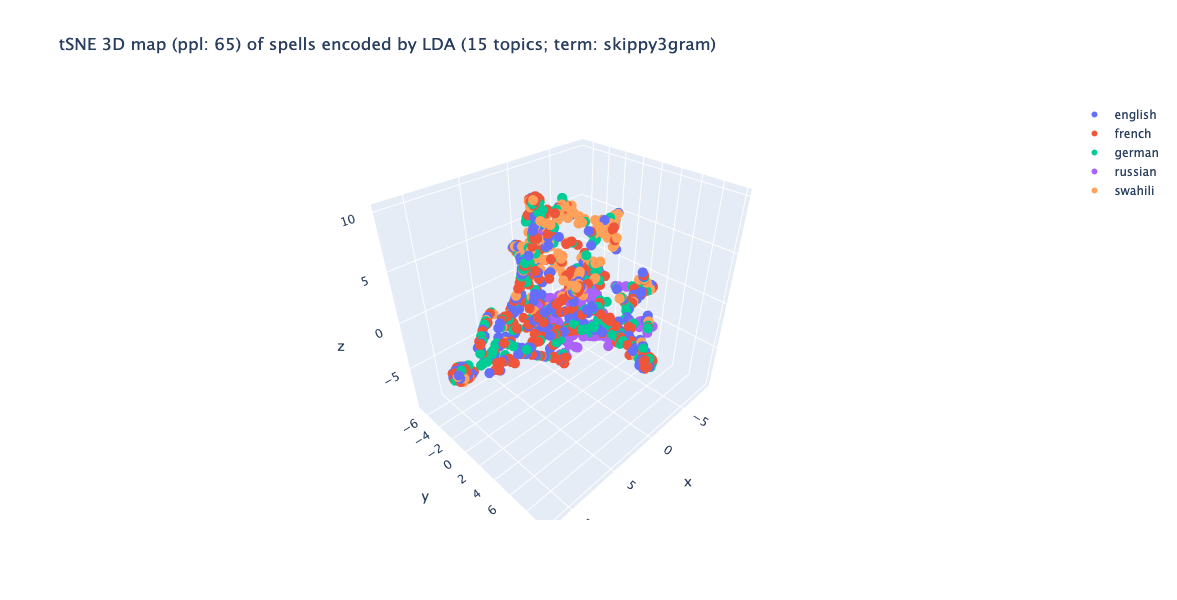

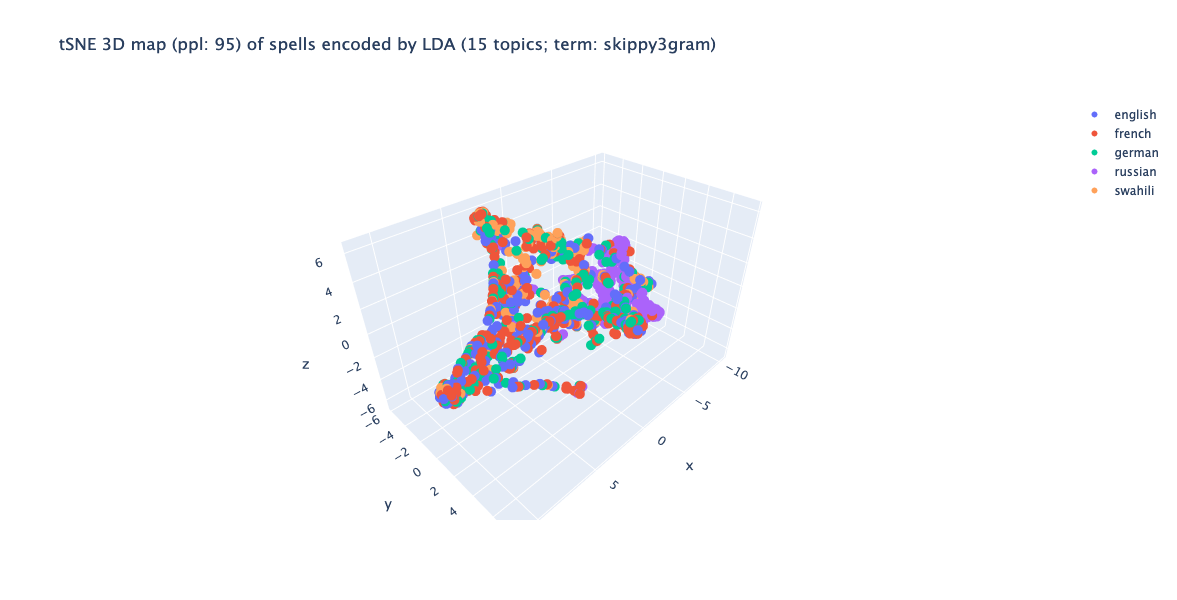

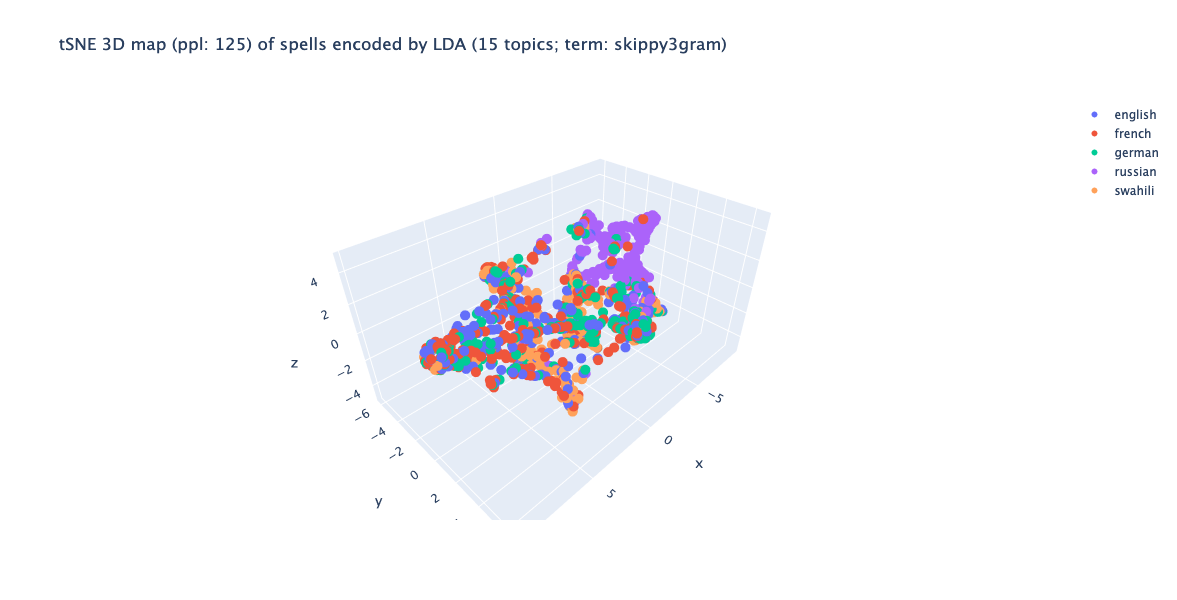

In [ ]:
## tSNE の結果の可視化: Plotly を使った 3D 描画

import numpy as np
from sklearn.manifold import TSNE as tSNE

import plotly.express as pex
import plotly.graph_objects as go
import matplotlib.pyplot as plt

## tSNE のパラメターを設定

perplexity_max_val = round(len(tSNE_df)/4)

for perplexity_val in range(5, perplexity_max_val, 30):
    
    ## tSNE 事例の生成
    tSNE_3d_varied = tSNE(n_components = 3, random_state = 0, perplexity = perplexity_val, n_iter = 1000)

    ## データに適用
    doc_enc = np.array(list(tSNE_df['enc']))
    doc_tSNE_3d_varied = tSNE_3d_varied.fit_transform(doc_enc)

    T = zip(doc_tSNE_3d_varied[:,0], doc_tSNE_3d_varied[:,1], doc_tSNE_3d_varied[:,2],
            tSNE_df['language']) # zip(..)が必要
    df = pd.DataFrame(T, columns = ['D1', 'D2', 'D3', 'language'])

    ## 作図
    fig = go.Figure()
    for lang in np.unique(df['language']):
        part = df[df['language'] == lang]
        fig.add_trace(
            go.Scatter3d(
                x = part['D1'], y = part['D2'], z = part['D3'],
                name = lang, mode = 'markers', marker = dict(size = 6),
                showlegend = True
            )
        )

    title_val = f"tSNE 3D map (ppl: {perplexity_val}) of {doc_attr}s encoded by LDA ({n_topics} topics; term: {term_type})"
    fig.update_layout(title = dict(text = title_val),
                      autosize = False, width = 600, height = 600,)
    fig.show()

In [50]:
## 階層クラスタリングのための事例のサンプリング

hc_sampling_rate = 0.1 # 大きくし過ぎると図が見にくい
df_size = len(tSNE_df)
hc_sample_n = round(df_size * hc_sampling_rate)
hc_df = tSNE_df.sample(hc_sample_n)
##
print(f"{hc_sample_n} rows are sampled")
hc_df['language'].value_counts()

141 rows are sampled


language
russian    33
english    32
french     32
german     24
swahili    20
Name: count, dtype: int64

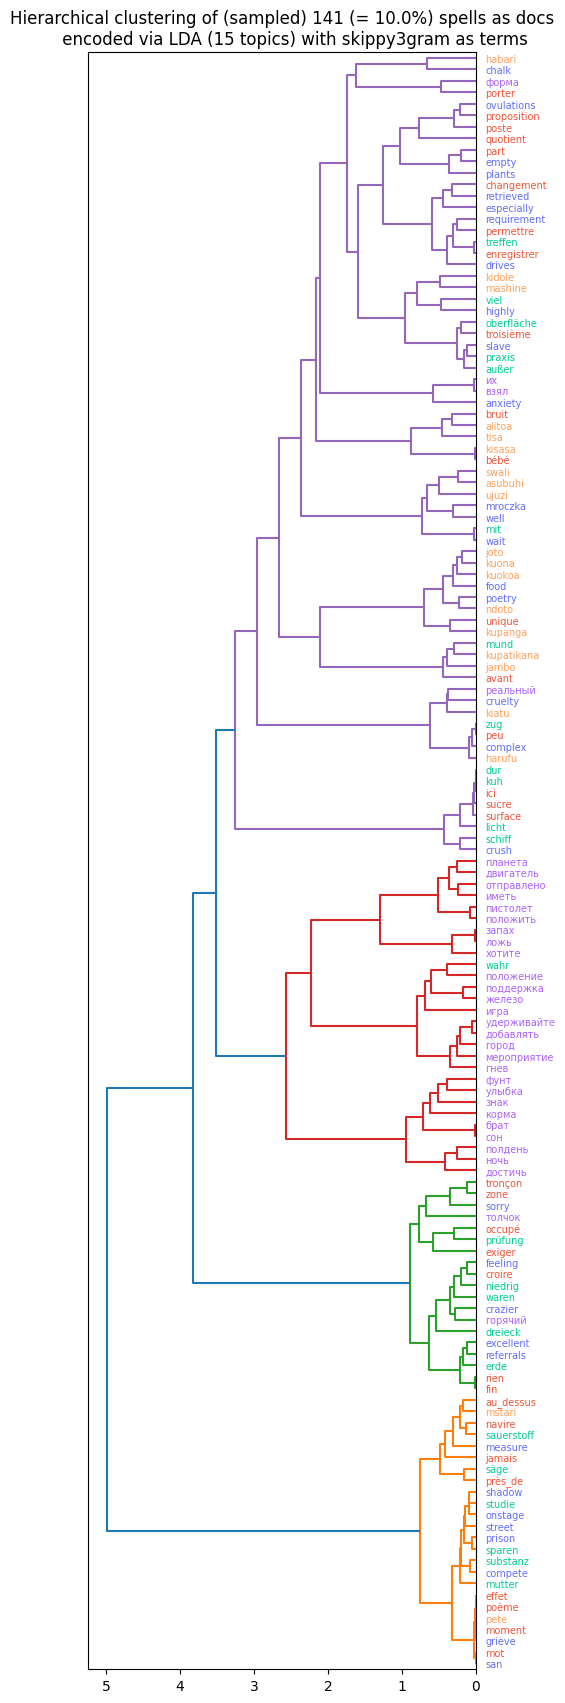

In [51]:
## doc 階層クラスタリングの実行

import numpy as np
import plotly
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage

## 距離行列の生成
Enc = list(hc_df['enc'])
linkage = linkage(Enc, method = 'ward', metric = 'euclidean')

## 描画サイズの指定
plt.figure(figsize = (5, round(len(hc_df) * 0.15))) # This needs to be run here, before dendrogram construction.

## 事例ラベルの生成
label_vals = [ x[:max_doc_size] for x in list(hc_df[doc_type]) ] # truncate doc keys

## 樹状分岐図の作成
dendrogram(linkage, orientation = 'left', labels = label_vals, leaf_font_size = 7)

## 描画
plt.title(f"Hierarchical clustering of (sampled) {len(hc_df)} (= {100 * hc_sampling_rate}%) {doc_attr}s as docs\n \
    encoded via LDA ({n_topics} topics) with {term_type} as terms")

## ラベルに language に対応する色を付ける
lang_colors = { lang_name : i for i, lang_name in enumerate(np.unique(hc_df['language'])) }
ax = plt.gca()
for ticker in ax.get_ymajorticklabels():
    form = ticker.get_text()
    row = hc_df.loc[hc_df[doc_type] == form]
    #lang = row['language']
    lang = row['language'].to_string().split()[-1] # trick
    try:
        lang_id = lang_colors[lang]
    except (TypeError, KeyError):
        print(f"color encoding error at: {lang}")
    #
    ticker.set_color(plotly.colors.qualitative.Plotly[lang_id]) # id の基数調整
#
plt.show()

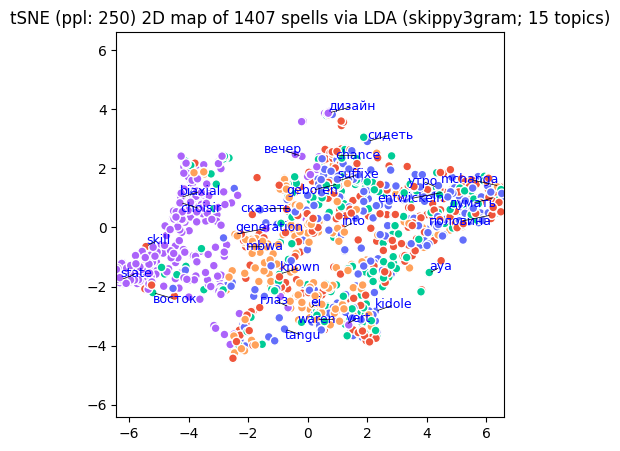

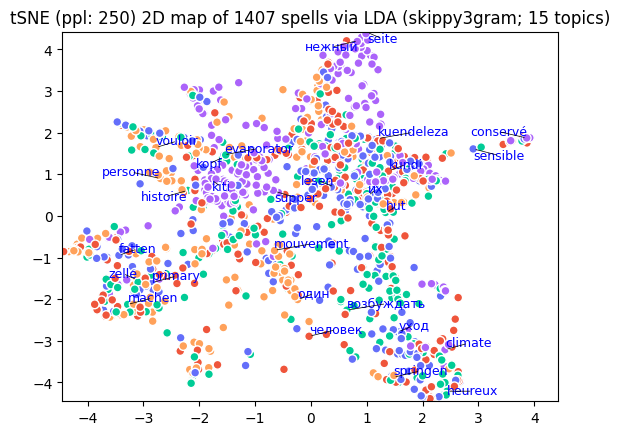

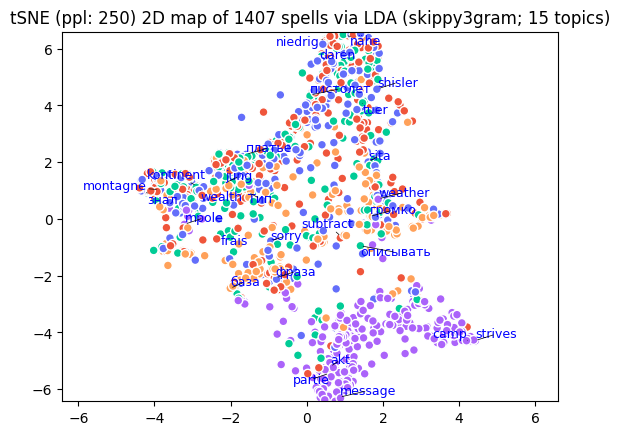

In [52]:
## tSNE の結果の可視化 (2D)

#import seaborn as sns
import numpy as np
import plotly
import plotly.express as pex
import matplotlib.pyplot as plt
from adjustText import adjust_text

## tSNE 事例の生成
perplexity_selected = 250
tSNE_3d = tSNE(n_components = 3, random_state = 0, perplexity = perplexity_selected, n_iter = 1000)

## データに適用
doc_enc = np.array(list(tSNE_df['enc']))
doc_tSNE_3d = tSNE_3d.fit_transform(doc_enc)

T = zip(doc_tSNE_3d[:,0], doc_tSNE_3d[:,1], doc_tSNE_3d[:,2],
        tSNE_df['language']) # zip(..)が必要
df = pd.DataFrame(T, columns = ['D1', 'D2', 'D3', 'language'])

## 描画
plt.figure(figsize = (5, 5))
plt.set_colors = pex.colors.qualitative.Plotly
    
for r in [ np.roll([0,1,2], -i) for i in range(0,3) ]:
    if check:
        print(r)
    X, Y = df.iloc[:,r[0]], df.iloc[:,r[1]]
    gmax = max(X.max(), Y.max())
    gmin = min(X.min(), Y.min())
    plt.xlim(gmin, gmax)
    plt.ylim(gmin, gmax)

    colormap = pex.colors.qualitative.Plotly
    lang_list = list(np.unique(tSNE_df['language']))
    cmapped = [ colormap[lang_list.index(lang)] for lang in df['language'] ]
    scatter = plt.scatter(X, Y, s = 40, c = cmapped, edgecolors = 'w')

    ## 文字を表示する事例のサンプリング
    lab_sampling_rate = 0.02
    lab_sample_n = round(len(tSNE_df) * lab_sampling_rate)
    sampled_keys = [ doc[:max_doc_size] for doc in random.sample(list(tSNE_df[doc_type]), lab_sample_n) ]

    ## labels の生成
    texts = [ ]
    for x, y, s in zip(X, Y, sampled_keys):
        texts.append(plt.text(x, y, s, size = 9, color = 'blue'))

    ## label に repel を追加: adjustText package の導入が必要
    adjust_text(texts, force_points = 0.2, force_text = 0.2,
                expand_points = (1, 1), expand_text = (1, 1),
                arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))
    #

    plt.title(f"tSNE (ppl: {perplexity_selected}) 2D map of {len(tSNE_df)} {doc_attr}s via LDA ({term_type}; {n_topics} topics)")
    #plt.legend(np.unique(cmapped))
    plt.show()